# Trace stability across multiple traces

In [1]:
import os
from pathlib import Path
import json
from datetime import timedelta
import pandas as pd
import numpy as np
from plotnine import *
from functools import reduce
from scipy import stats
# import os
# import math

In [2]:
# Configure paths
constant = [
    '2021-04-12_08-29-36',
    '2021-04-12_09-15-56',
    '2021-04-12_09-50-10'
]
constant_88_rpm = [
    '2021-04-12_10-37-39',
    '2021-04-12_14-44-58',
    '2021-04-12_19-28-19',
    '2021-04-12_20-16-35'
]
spikes = [
    '2021-04-12_20-58-10',
    '2021-04-13_08-31-39',
    '2021-04-13_09-50-26'
]
constant_1rps = [
    '2021-04-13_10-57-38',
    '2021-04-13_11-28-26',
    '2021-04-13_12-05-41'
]
constant_5rps = [
    '2021-04-13_13-22-12',
    '2021-04-13_13-54-03',
    '2021-04-13_14-10-09',
    '2021-04-13_14-41-49',
    '2021-04-13_15-10-51'
]

constant_vs_bursty_1h = [
    '2021-04-30_15-43-35', # constant
    '2021-04-30_17-31-33'  # bursty 
]

patterns_20rps = [
    '2021-04-30_03-48-52', # constant
    '2021-04-30_04-41-31', # bursty
    '2021-04-30_05-34-22', # jump
    '2021-04-30_06-23-37'  # spikes
]

# traces_dir = Path('data/ec2/ec2-user/faas-migration/ThumbnailGenerator/Lambda/logs')
# traces_dir = Path('/Volumes/CTH-JOEL/serverless-study/data/lg6/ec2-user/faas-migration/Event-Processing/Lambda/logs')
traces_dir = Path('/Volumes/CTH-JOEL/serverless-study/data/lg3/ec2-user/faas-migration/Event-Processing/Lambda/logs')
executions = patterns_20rps

In [3]:
def read_trace(execution):
    traces_path = traces_dir / execution / 'trace_breakdown.csv'
    df = pd.read_csv(traces_path)
    # see CSV_FIELDS in aws_trace_analyzer.py
    timedelta_cols = [
        'duration',
        'orchestration',
        'trigger',
        'container_initialization',
        'runtime_initialization',
        'computation',
        'queing',
        'overhead',
        'external_service',
        'unclassified'
    ]
    df[timedelta_cols] = df[timedelta_cols].apply(pd.to_timedelta)
    # Optionally: select columns
    df = df[['trace_id', 'start_time', 'duration', 'num_cold_starts']]
    traces_start = df['start_time'].min()
    df['relative_time'] = df['start_time'] - traces_start
    df = df.sort_values(by=['relative_time'])
    return df

dfs = map(read_trace, executions)
df_merged = pd.concat(dfs, keys=executions)
df_merged.reset_index(level=0, inplace=True)
df_merged.rename(columns={'level_0': 'execution'}, inplace=True)
# df_merged.head()

In [4]:
df_merged.describe()

,start_time,duration,num_cold_starts,relative_time
count,9.289100e+04,92891,92891.000000,92891.000000
mean,1.619759e+09,0 days 00:00:00.018439472,0.000161,588.062184
std,3.574878e+03,0 days 00:00:00.010263337,0.012707,353.132157
min,1.619755e+09,0 days 00:00:00.012000,0.000000,0.000000
25%,1.619755e+09,0 days 00:00:00.016000,0.000000,260.902500
50%,1.619759e+09,0 days 00:00:00.018000,0.000000,582.275000
75%,1.619762e+09,0 days 00:00:00.019000,0.000000,897.661000
max,1.619765e+09,0 days 00:00:00.764000,1.000000,1198.160000


In [5]:
df_merged[['duration', 'num_cold_starts', 'execution']].groupby('execution').describe()

duration                             \
                       count                       mean   
execution                                                 
2021-04-30_03-48-52    29617  0 days 00:00:00.017867407   
2021-04-30_04-41-31    18315  0 days 00:00:00.017969696   
2021-04-30_05-34-22    23726  0 days 00:00:00.019070091   
2021-04-30_06-23-37    21233  0 days 00:00:00.018937973   

                                                                        \
                                           std                     min   
execution                                                                
2021-04-30_03-48-52  0 days 00:00:00.009356497  0 days 00:00:00.013000   
2021-04-30_04-41-31  0 days 00:00:00.009859807  0 days 00:00:00.012000   
2021-04-30_05-34-22  0 days 00:00:00.011608616  0 days 00:00:00.013000   
2021-04-30_06-23-37  0 days 00:00:00.010146648  0 days 00:00:00.013000   

                                                                     \
                                        25%                     50%   
execution                                                             
2021-04-30_03-48-52  0 days 00:00:00.016000  0 days 00:00:00.017000   
2021-04-30_04-41-31  0 days 00:00:00.016000  0 days 00:00:00.017000   
2021-04-30_05-34-22  0 days 00:00:00.017000  0 days 00:00:00.018000   
2021-04-30_06-23-37  0 days 00:00:00.017000  0 days 00:00:00.018000   

                                                                     \
                                        75%                     max   
execution                                                             
2021-04-30_03-48-52  0 days 00:00:00.018000  0 days 00:00:00.662000   
2021-04-30_04-41-31  0 days 00:00:00.019000  0 days 00:00:00.674000   
2021-04-30_05-34-22  0 days 00:00:00.020000  0 days 00:00:00.764000   
2021-04-30_06-23-37  0 days 00:00:00.019000  0 days 00:00:00.697000   

                    num_cold_starts                                          \
                              count      mean       std  min  25%  50%  75%   
execution                                                                     
2021-04-30_03-48-52         29617.0  0.000135  0.011621  0.0  0.0  0.0  0.0   
2021-04-30_04-41-31         18315.0  0.000164  0.012798  0.0  0.0  0.0  0.0   
2021-04-30_05-34-22         23726.0  0.000211  0.014516  0.0  0.0  0.0  0.0   
2021-04-30_06-23-37         21233.0  0.000141  0.011886  0.0  0.0  0.0  0.0   

                          
                     max  
execution                 
2021-04-30_03-48-52  1.0  
2021-04-30_04-41-31  1.0  
2021-04-30_05-34-22  1.0  
2021-04-30_06-23-37  1.0

In [6]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

print(df_merged[['duration']].apply(cv))
print(df_merged[['duration', 'num_cold_starts', 'execution']].groupby('execution')[['duration']].apply(cv))

duration    55.659603
dtype: float64
                      duration
execution                     
2021-04-30_03-48-52  52.366283
2021-04-30_04-41-31  54.869081
2021-04-30_05-34-22  60.873417
2021-04-30_06-23-37  53.578321


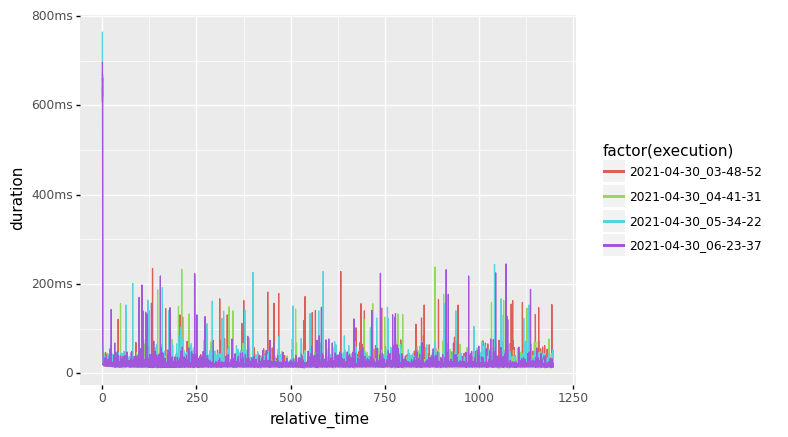

<ggplot: (300699001)>

In [7]:
filtered = df_merged[df_merged['duration'] < timedelta(milliseconds=2000)]
(
    ggplot(df_merged)
    + aes(x='relative_time', y='duration', color='factor(execution)')
    + geom_line()
    # Minute separators
    # + geom_vline(xintercept=range(0, 1250, 60), color='lightgrey')
)

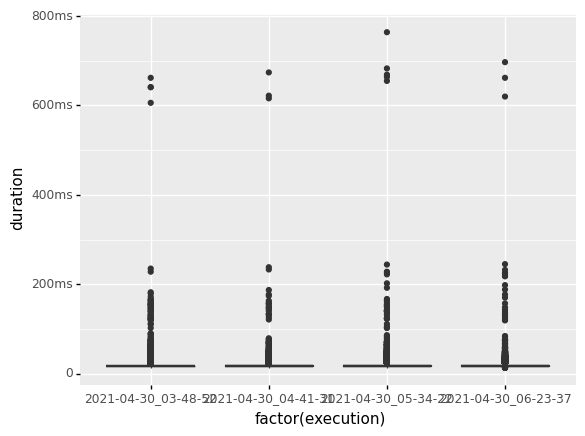

<ggplot: (301419857)>

In [8]:
(
    ggplot(df_merged)
    + aes(x="factor(execution)", y="duration")
    + geom_boxplot()
    # won't work for large 1h traces
    # + geom_violin()
)

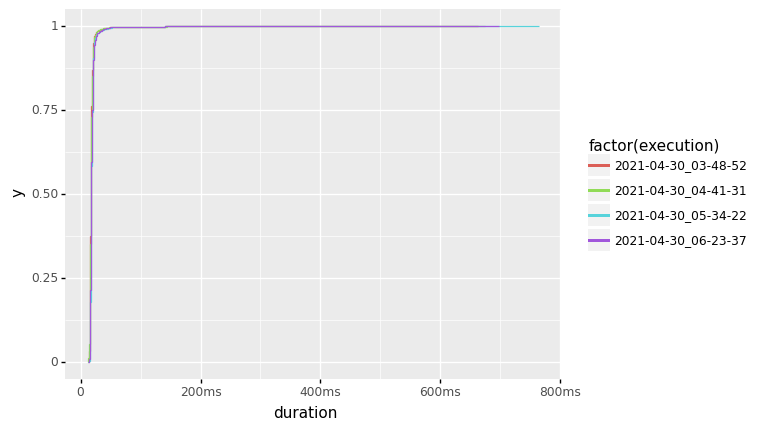

<ggplot: (301458129)>

In [9]:
(
    ggplot(df_merged)
    + aes(x="duration", color='factor(execution)')
    + stat_ecdf(geom='step', position='identity')
)